# Setup

In [121]:
import numpy as np
import scipy.io as si
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler

# Matplotlib colors
colors = plt.cm.rainbow(np.linspace(0, 1, 8))
cmap = ListedColormap(colors)

In [59]:
# Load Data
data_path = '/Users/darinmomayezi/Documents/School/Centuri Summer School/Computational Neuroscience/data/'
dataset1 = si.loadmat(data_path + 'Dataset1.mat')
header, version, globals, directions, R = dataset1['__header__'], dataset1['__version__'], dataset1['__globals__'], dataset1['direction'], dataset1['R']
neurons, trials = R.shape
directions = directions.reshape(158,)

# Getting Started: Visualize the Data

Text(0.5, 1.0, 'Data')

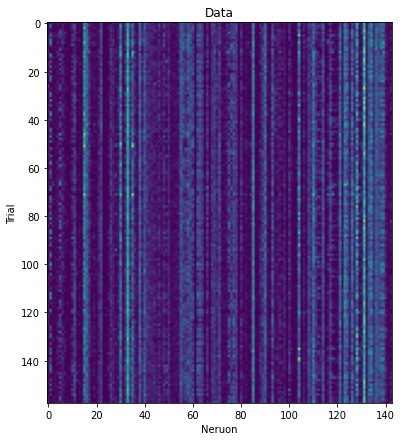

In [19]:
fig = plt.figure(figsize=(9, 7))
plt.imshow(R.T)

plt.xlabel('Neruon')
plt.ylabel('Trial')
plt.title('Data')

The above data shows the firing rate (Hz) of each neuron during each trial. This is far too much data to analyze at once so let's try other ways to explore the data.

# Mean Firing Rate of First Neuron in Each Direction

Let's explore how the firing rate of a single neuron averages over all trials changes with the direction of the task. You can change the neuron to plot by changing the 'neuron' variable.

Text(0.5, 1.0, 'Mean Firing Rate of Neuron 1')

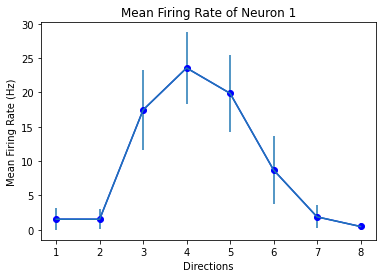

In [134]:
# Directional mean firing rate
neuron = 1  # Neuron of interest
fig, ax = plt.subplots(nrows=1, ncols=1)
directional_mean_firing_rate = []
directional_std = []
trial_direction_dict = {}
for i in range(1, 9):
    directional_mean_firing_rate.append(np.mean(R[neuron][directions == i]))
    directional_std.append(np.std(R[neuron][directions == i]))

for trial, direction in enumerate(directions):
    if direction not in trial_direction_dict.keys():
        trial_direction_dict[direction] = [trial]
    else:
        trial_direction_dict[direction].append(trial)
        
ordered_trial_dict = {}
for direction in range(1, 9):
    ordered_trial_dict[direction] = trial_direction_dict[direction]
    
for index, direction in enumerate(directions):
    if direction not in trial_direction_dict.keys():
        trial_direction_dict[direction] = [index]
    else:
        trial_direction_dict[direction].append(index)
  
plt.errorbar([i for i in range(1, 9)], directional_mean_firing_rate, yerr=directional_std)
ax.plot(np.linspace(1, 8, 8), directional_mean_firing_rate, marker='o', color='blue')

plt.xlabel('Directions')
plt.ylabel('Mean Firing Rate (Hz)')
plt.title(f'Mean Firing Rate of Neuron {neuron}')

### Let's plot the rest of the neurons

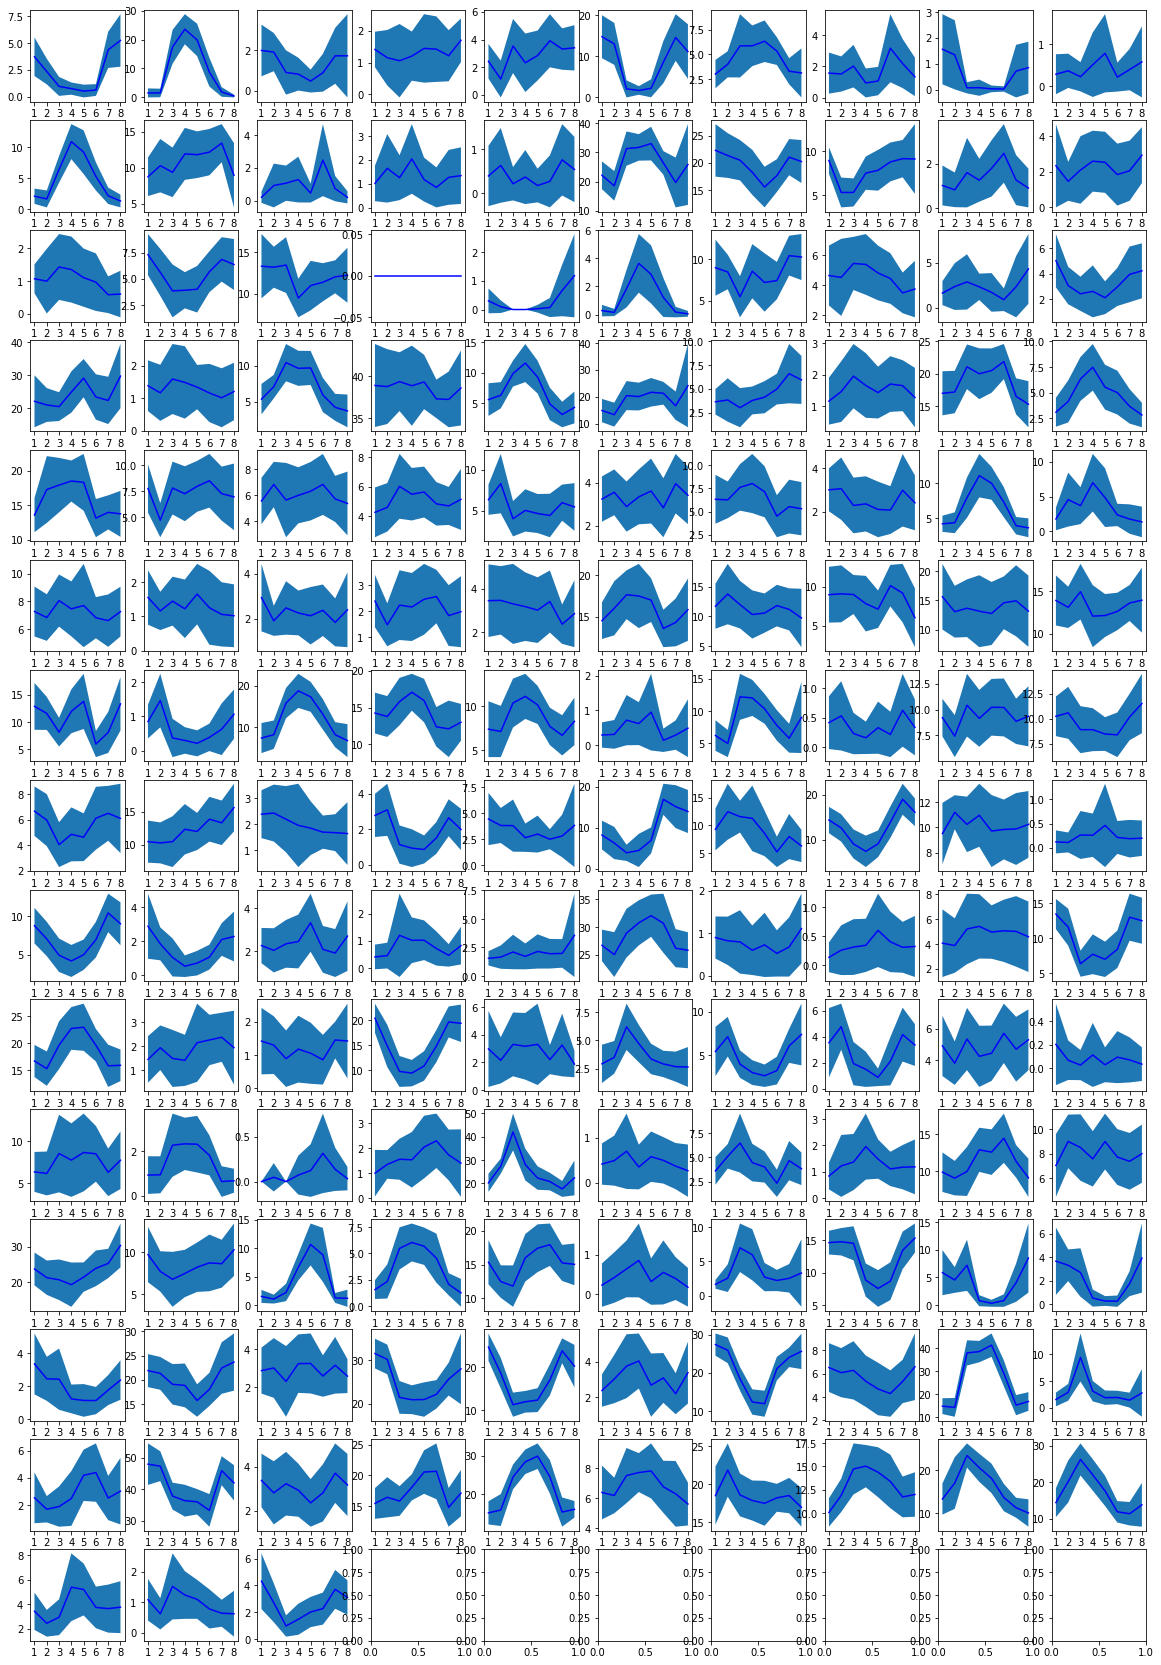

In [98]:
fig, ax = plt.subplots(nrows=15, ncols=10, figsize=(20, 30))
for neuron in range(neurons):
    directional_mean_firing_rate = []
    directional_std = []
    for i in range(1, 9):
        directional_mean_firing_rate.append(np.mean(R[neuron][directions == i]))
        directional_std.append(np.std(R[neuron][directions == i]))
    
    directional_mean_firing_rate = np.array(directional_mean_firing_rate)
    directional_std = np.array(directional_std)
    
    # ax[neuron//10][neuron%10].errorbar([i for i in range(1, 9)], directional_mean_firing_rate, yerr=directional_std)  # errorbar
    ax[neuron//10][neuron%10].plot(np.linspace(1, 8, 8), directional_mean_firing_rate, color='blue')
    ax[neuron//10][neuron%10].fill_between(range(1, 9), directional_mean_firing_rate - directional_std, directional_mean_firing_rate + directional_std)
    ax[neuron//10][neuron%10].set_xticks(np.linspace(1, 8, 8))

One neuron has flatlined! Not a hard worker that one. These plots show that neurons have prefered directions because they fire at a greater rate in some directions than others. Therefore, we fit the data using a Von Mises distrbution, which is a continuous probability distrbution on the circle. A prewritten program will fit the data to the Von Mises distrbituion using the $ \theta_0 $ parameter in the Von Mises equation below. $ \theta_0 $ will tell us the 'preferred' direction of each neuron and we call the fits plotted in orange 'tuning curves'. 
$$ VM = bs + e^{ \kappa \cos (2 ( \theta - \theta_0) / \theta_b)} (f_{ max} - bs) $$

In [82]:
# Von Mises fit algorithm

def tuning_function(theta, theta0, kappa, fmax, bsl, theta_bound):
    # Von Mises, with kappa the concentration, theta0 the location
    # fmax the firing rate at pref ori, bsl the min firing rate (not the baseline, which was substracted) 
    tf = bsl + np.exp(kappa*(np.cos(2*np.pi/theta_bound*(theta-theta0))-1)) * (fmax-bsl)
    return tf

# we will use the tutorial from https://lmfit.github.io/lmfit-py/model.html :
from lmfit import Model, Parameters

def fit_tc(array, init_kappa, theta_bound=2*np.pi):
    """
    Fits the data points in `array` to `tuning_function`.
    
    set theta_bound to 2*np.pi for fitting signed angles (eg dirrection)
    or to np.pi for an unsigned one (like orientation)
    """
              
    theta = np.linspace(0, theta_bound, len(array), endpoint=False)
    mod = Model(tuning_function)
    pars = Parameters()
    #               name    default           vary  min   max
    pars.add_many(('theta0', theta[np.argmax(array)], True, 0., theta_bound),
                  ('kappa', init_kappa, True,  .1, 5.),
                  ('fmax', np.max(array), True, 0.0, 2*np.max(array)+5),
                  ('bsl', np.min(array), True, 0.0, np.max(array)+5),
                  ('theta_bound', theta_bound, False))
                
    out = mod.fit(array, pars, theta=theta, nan_policy='omit', max_nfev=50000)
    
    return out.best_values

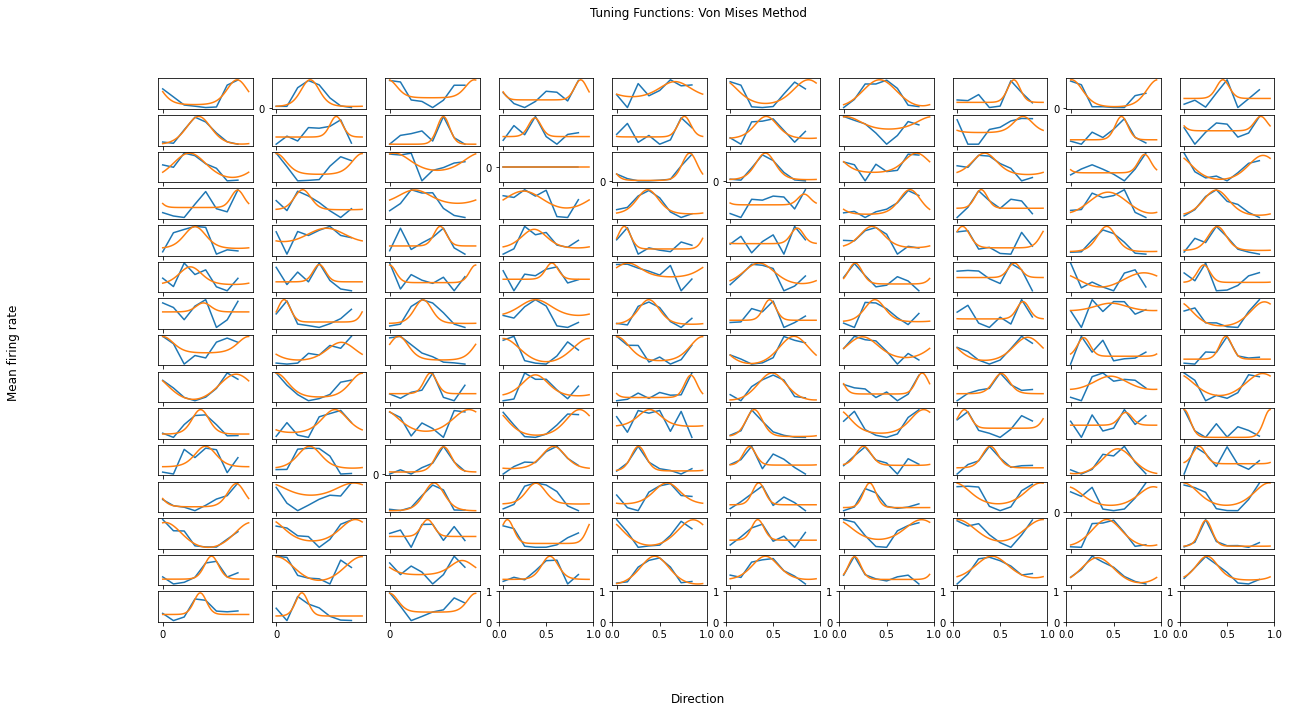

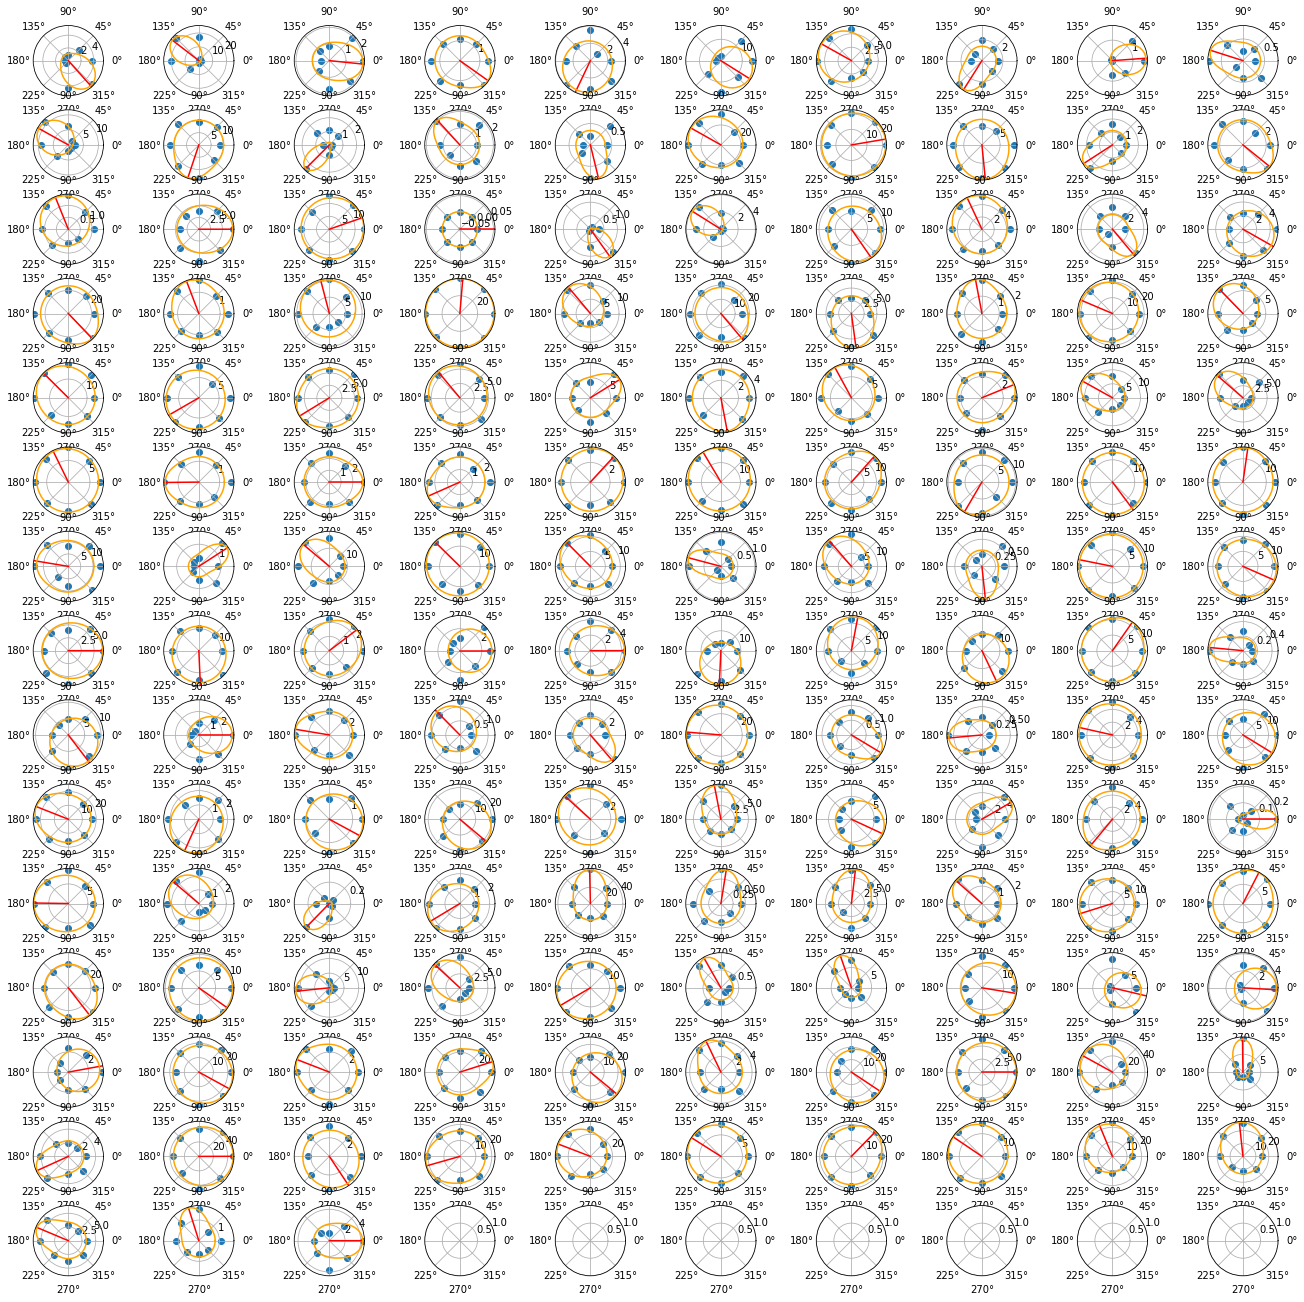

In [100]:
fig, ax = plt.subplots(figsize=(20, 10), nrows=15, ncols=10)
fig1, ax1 = plt.subplots(15, 10, figsize=(23, 23), squeeze = False, subplot_kw={'projection': 'polar'})
theta_0_array = []
for neuron in range(neurons):
    
    directional_mean_firing_rate = []
    for i in range(1, 9):
        directional_mean_firing_rate.append(np.mean(R[neuron][directions == i]))
    
    fr_dict = {}  # firing rates for each direction
    
    for directional in range(1, 9):
        fr_dict[directional] = R[neuron][directions == directional]
    
    fr_array = np.zeros(len(fr_dict.keys()))      
    for direction, fr_list in fr_dict.items():
        fr_array[direction-1] = np.mean(fr_list)
        
    N_directions = 8
    theta_bound = 2*np.pi
    theta = np.linspace(0, theta_bound, N_directions, endpoint=False)
    array = tuning_function(theta, theta0=np.pi/4, kappa=2., fmax=20., bsl=1., theta_bound=theta_bound) + 0.1*np.abs(np.random.randn(N_directions))
                    
    fitted_params = fit_tc(fr_array, 10)
    theta_0_array.append(fitted_params['theta0'])
    ax[neuron//10][neuron%10].plot(theta, fr_array)
    theta_more = np.linspace(0, theta_bound, 60, endpoint=True)
    ax[neuron//10][neuron%10].plot(theta_more, tuning_function(theta_more, **fitted_params))

    ax[neuron//10][neuron%10].set_yticks([0])
    ax[neuron//10][neuron%10].set_xticks([0])
    
    # Polar plots
    ax1[neuron//10][neuron%10].scatter(theta, np.array(directional_mean_firing_rate), marker='o')
    ax1[neuron//10][neuron%10].axvline(fitted_params['theta0'], color = 'red')
    ax1[neuron//10][neuron%10].plot(theta_more, tuning_function(theta_more, **fitted_params), color='orange')
fig.supxlabel('Direction')
fig.supylabel('Mean firing rate')
fig.suptitle('Tuning Functions: Von Mises Method')
plt.show()

The first set of plots shows the true data vs. the fitted data, which shows that the Von Mises distribution provides a good fit. Therefore, the $ \theta_0 $ variable does show the preferred direction. The second group of plots is polar plots that show the Von Mises fit in its circular geometry. The red line shows the preferred direction based on the $ f_{max} $ parameter and provides an intuitive interpretation of the neuron firing rate. Remember each plot is a different neuron, so we are finding the preferred direction of each neuron. We can make an even more concise graph by plotting the distribution of preferred directions on the circle. 

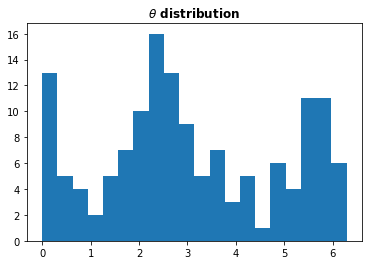

In [104]:
plt.hist(theta_0_array, bins=20)
plt.title('$\\theta$ distribution', fontweight = 'bold')
plt.show()

Now we wrap this $ \theta $ distribution around the circle. 

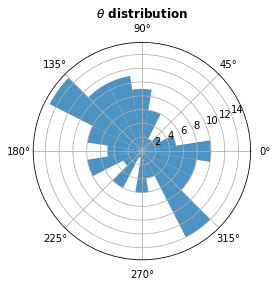

In [106]:
radii = [10.,  5.,  3.,  2.,  6.,  9., 11., 11., 15.,  8.,  5.,  8.,  3.,
         6.,  1.,  6.,  4., 14.,  8.,  8.]

angles = [0,0.31415927, 0.62831853, 0.9424778 , 1.25663706,
        1.57079633, 1.88495559, 2.19911486, 2.51327412, 2.82743339,
        3.14159265, 3.45575192, 3.76991118, 4.08407045, 4.39822971,
        4.71238898, 5.02654825, 5.34070751, 5.65486678, 5.96902604,]

width = (2*np.pi) / len(radii)

ax = plt.subplot(111, polar=True)
bars = ax.bar(angles, radii, width = width)

# Use custom colors and opacity
for r, bar in zip(radii, bars):
    bar.set_alpha(0.8)
ax.set_title('$\\theta$ distribution', fontweight = 'bold')

plt.show()

Directions near $ 135 \degree $ and $ 115 \degree $ are clearly overrepresented, which means many more neurons are required to perform these movements. This may be due to the fact that diagonal movements require a movement of both joints in the arm, namely the elbow and shoulder. Therefore, we can explain this through the geometry of the arm, but we didn't assume that before! It came directly from the neuronal activity, however, it is a conjecture until we perform an experiment to validate this hypothesis. 

At this point we have successfully uncovered the circular geometry of this activity solely from neuronal activity by: 

1. Exploring the data in a smart way (activity vs. direction, averaged over trials) and noticing a directionality
2. Using the Von Mises distribution (motivated by step 1) to find a parameter $ \theta_0 $ (preferred direction of neuron)
3. Plotting useful information in the appropriate geometrical format (polar plot for the circular geometry of the Von Mises distribution) to obtain interpretible information. 
 
### Now, can we decode the detailed movement of the monkey's arm solely from neuronal activity?

In the following section we will show this is possible by using two methods:
1. Logistic Regression
2. Neural Networks

This task will inevitably require some form of dimensionality reduction since we hope to obtain one piece of information as output (the direction that the moneky points) from 143 neurons of input. So, we first employ principle component analysis to get a naive estimate of how high dimensional the input is. We say it is 'naive' because there is no reason that a linear dimensionality reduction method will represent the neuronal data well, i.e. we expect the neuronal data to be moderately to highly non-linear. 

# Principle Components Analysis (PCA)

(158, 2)
0.43838951138059024


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


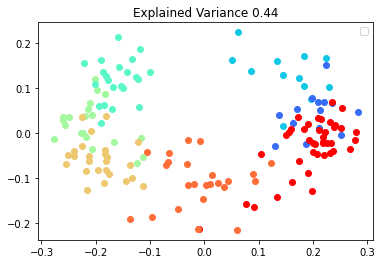

In [113]:
R_prime = normalize(R.T)
R_prime = R_prime - np.mean(R_prime, axis=0)
pca = PCA(n_components=2, svd_solver='full')
pca.fit(R_prime)  # fit normalized data to princ_comps
explained = pca.explained_variance_ratio_  # variance explained by each component
princ_comps = pca.components_
projected = pca.transform(R_prime)
print(projected.shape)
fig = plt.subplot()
print(sum(explained))

for trial_index, trial in enumerate(projected):
    # do coloring
    for direction, trials in trial_direction_dict.items():
        for trial_sample in trials:
            if trial_sample == trial_index:
                fig.scatter(projected[trial_index, 0], projected[trial_index, 1], color=cmap(direction))


# fig4.scatter(projected[:, 0], projected[:, 1], marker='o')
fig.set_title(f'Explained Variance {round(sum(explained), 2)}')
fig.legend()

We are correct in our assumption that PCA will not represent the data very well. The first two components explain 44% of the variance in the data, which isn't bad, but playing around with the code shows that we need about 40 components to explain 90% or more of the data. PCA is still useful, however. One thing to notice is that information is fairly well spread over the neurons precisely because we need 40+ components to explain 90% of the data. Why is that? Well, as a phycisist who doesn't know about neuroscience I asked the question, 'how can we possibly insert electrodes in the brain and happen upon THE 143 neurons that produce the monkey's movement?' The answer is that information is actually spread out pretty well over parts of the brain. This means that the activity of most neurons in the motor cortex are somehow correlated to each movement we do. Perhaps this redundancy is an evolutionary advantage since, while less efficient, redundancy provides more security is some wiring goes awry. Anyways, this is something interesting to notice. Another reason PCA is useful is because now we can visualize the data in a two-dimensional space. Since we can't visually percieve more than three dimensions this is very useful. 

### Remember, we have a continuous represenation of the data with $ \theta_0 $.

Let's recall that the original task is performed with discrete directions 1-8 around the circle, but with the Von Mises fit we can create a continuous representation of the data through interpolation. Therefore, with the same 143 neurons we can predict any direction the monkey could move if it were allowed to move in any direction around the circle. 

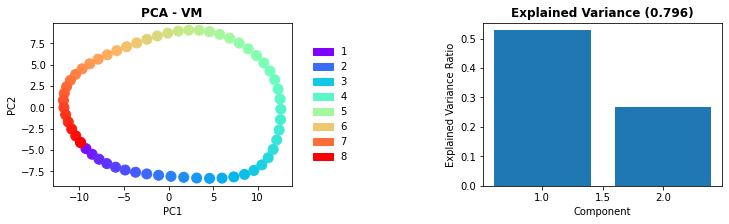

In [123]:
# Interpolate data with Von Mises fit
scaler = StandardScaler()

VM = []
init_kappa = 3.5
N_directions = 8
theta_bound = 2 * np.pi
theta = np.linspace(0, theta_bound, N_directions, endpoint = False)
theta_more = np.linspace(0, theta_bound, 60, endpoint = True)


for neuron in range(neurons):
        
    ########################
    # Retrieve mean firing rates for each neuron at each direction
    mean_firing = []
    
    for i in range(1, 9): # Moving along 'directions'
        mean_firing.append(np.mean(R[neuron][directions == i]))
    mean_firing = np.array(mean_firing)

    fitted_params = fit_tc(mean_firing, init_kappa = init_kappa)  # VM fit
    VM.append(tuning_function(theta_more, **fitted_params))
    
VM = np.array(VM)

VM_projected = scaler.fit_transform(VM.T)
n_components = 2
pca = PCA(n_components=n_components)
pca.fit(VM_projected)

# Transform the scaled data to the principal components
data_t_reduced_VM = pca.transform(VM_projected)

fig = plt.figure(figsize = (12,3))
fig.subplots_adjust(wspace = 0.8)

plt.subplot(121)
colors_m = plt.cm.rainbow(np.linspace(0, 1, len(theta_more)))
plt.scatter(data_t_reduced_VM[:, 0], data_t_reduced_VM[:, 1], color = colors_m, s = 1e2)


plt.title('PCA - VM', fontweight = 'bold')
plt.xlabel('PC1')
plt.ylabel('PC2')

# Add legends as style (this can be ommited)
handles = []
for i in range(8):
    exec('patch{} = mpatches.Patch(color = colors[{}], label =  "{}")'.format(i + 1, i, i + 1))
    handles.append(eval('patch{}'.format(i + 1)))

plt.legend(handles = handles, loc = 'center left', bbox_to_anchor = (1.05, 0.5), frameon = False)

plt.subplot(122)
plt.bar([i + 1 for i in range(n_components)], pca.explained_variance_ratio_)
plt.title('Explained Variance ({})'.format(round(pca.explained_variance_ratio_.sum(), 3)), fontweight = 'bold')
plt.xlabel('Component')
plt.ylabel('Explained Variance Ratio')
plt.show()

This ring shows us that with the neuronal data from the 143 neurons we can predict any directions in $ 360 \degree $ that the monkey will move! Therefore, we have created a CONTINUOUS REPRESENTATION. Let's take a minute to appreciate how we did this. First, we already have the PCA fit that we did previously on the discrete directions. Then, we applied the Von Mises fit to each neuron, taking into account its mean activity in each direction, to obtain the tuning function, i.e. the continous representation. And to visualize in the PCA space we projected this fitted data onto the first two principle components to obtain this ring. Using the principle components is one way, but not the best way, to decode the direction of motion from the neuronal activity.

# Neural Network

Now, we introduce a neural network for decoding. We have decided to formulate the network as a regression task rather than a classification task, however, both achieve the same results. The architecutre is very simple: four linear layers with three Sigmoid functions in between. IMPORTANT: the network does not end with a Sigmoid since its output is limited from 0-1 while we are predicting output from 1-8 (for each of the directions).

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Evaluation Loss: 4.155695577578929
Evaluation Loss: 4.158763739746064
Evaluation Loss: 4.158056265984972
Evaluation Loss: 4.157711374874149
Evaluation Loss: 4.157506959265447
Evaluation Loss: 4.15737295866226
Evaluation Loss: 4.157279511084198
Evaluation Loss: 4.157211559562711
Evaluation Loss: 4.157160404666986
Evaluation Loss: 4.157120860433982
Evaluation Loss: 4.157089479539233
Evaluation Loss: 4.15706472711948
Evaluation Loss: 4.157044707249345
Evaluation Loss: 4.157027740215805
Evaluation Loss: 4.157014291617088
Evaluation Loss: 4.157002777331702
Evaluation Loss: 4.1569932445660625
Evaluation Loss: 4.156985569604633
Evaluation Loss: 4.156977910727922
Evaluation Loss: 4.1569715808194205
Evaluation Loss: 4.156966522428168
Evaluation Loss: 4.1569623242151765
Evaluation Loss: 4.156958022135465
Evaluation Loss: 4.1569549886044115
Evaluation Loss: 4.1569517689495115
Evaluation Loss: 4.156949094409356
Evaluation Loss: 4.156946429740249
Evaluation Loss: 4.156944121971416
Evaluation Loss: 

Text(0.5, 1.0, 'Neural Decoding of Directions \n Evaluation Accuracy: 83.0 %')

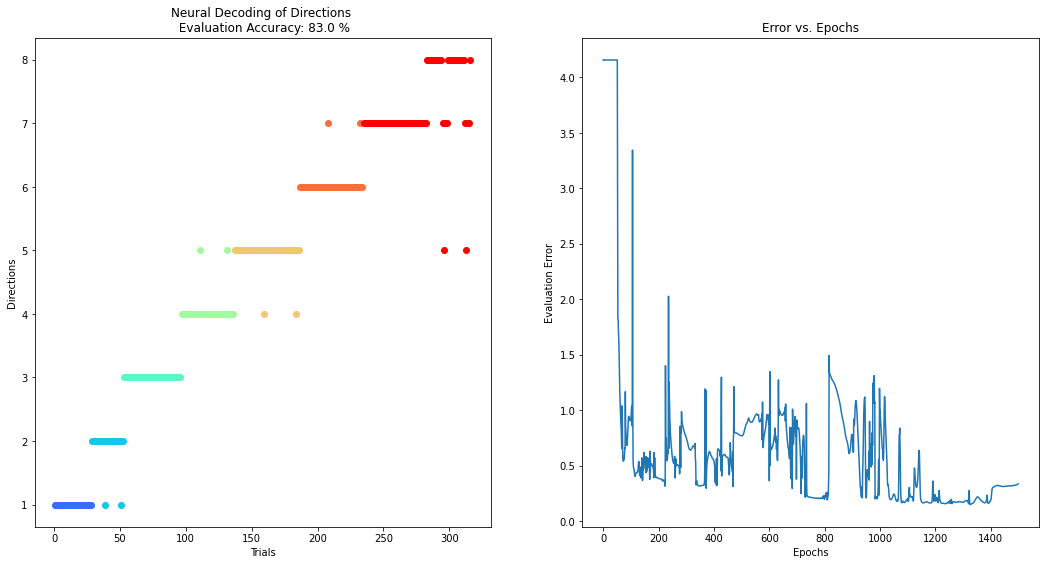

In [150]:
# Decoding

# ML Imports
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Hyperparameters
batch_size = 1
lr = 0.01
epochs = 1500
shuffle = False

# Train/Test Sets
train_ratio = 0.7
R_train = np.array(normalize(R.T[:int(R.T.shape[0]*train_ratio)]))
R_test = np.array(normalize(R.T[int(R.T.shape[0]*train_ratio):]))
train_data = TensorDataset(torch.Tensor(R_train))
eval_data = TensorDataset(torch.Tensor(R_test))
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=shuffle)
eval_loader = DataLoader(dataset=eval_data, batch_size=batch_size, shuffle=shuffle)

# Data to save/access later
eval_loss = []

# Define the Model
def autoencoder():
    
    # Data to return later
    encodings = []
    feature1 = []
    feature2 = []
    
    class Autoencoder(torch.nn.Module):
        def __init__(self):
            super().__init__()
            
            self.encoder = nn.Sequential(nn.Linear(143, 100, bias=True, dtype=torch.float32),
                                            nn.Sigmoid(),
                                            nn.Linear(100, 50, bias=True, dtype=torch.float32),
                                            nn.Sigmoid(),
                                            nn.Linear(50, 15, bias=True, dtype=torch.float32),
                                            nn.Sigmoid(),
                                            nn.Linear(15, 1, bias=True, dtype=torch.float32))
        
        def forward(self, x):
            
            encoded = self.encoder(x)
            # encoded = self.activation(encoded)
            if epoch == epochs-1:  # save encoding for each trial
                encodings.append(encoded[0].clone().item())
            
            return encoded
        
    model = Autoencoder()
    model.eval()
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=100, factor=0.5)
    
    def evaluate(model, eval_loader):
        model.eval()
        running_loss = 0
        for i, x in enumerate(eval_loader):
            # x = torch.tensor(np.array([x[0][0][0], x[0][0][1]]))
            x = x[0]
            trial = int(R.T.shape[0]*train_ratio) + i
            label = torch.tensor(directions[trial], dtype=torch.float32)
            recon = model(x)
            loss = criterion(recon, label)
            running_loss += loss.item()
        epoch_loss = running_loss / len(eval_loader)
        eval_loss.append(epoch_loss)
        print(f'Evaluation Loss: {epoch_loss}')
    
    # Training loop
    for epoch in range(epochs):
        running_loss = 0     
        for i, x in enumerate(train_loader):
            # x = torch.tensor(np.array([x[0][0][0], x[0][0][1]]))
            x = x[0]
            x.requires_grad = True
            label = torch.tensor(directions[i], dtype=torch.float32)
            model.train()
            optimizer.zero_grad()
            recon = model(x)
            loss = criterion(recon[0][0], label)
            running_loss += loss.item()
            loss.backward()
            optimizer.step()
        epoch_loss = running_loss / len(train_loader)
        scheduler.step(epoch_loss)
        
        evaluate(model, eval_loader)
        
        # Weight histogram
        
    return encodings, feature1, feature2
        
encodings_data, feature1_data, feature2_data = autoencoder()
fignn, axnn = plt.subplots(nrows=1, ncols=2, figsize=(18, 9))

# Convert encodings to integers
index = 0
for trial, encoding in enumerate(encodings_data):
    encodings_data[trial] = int(round(encoding, 0))

index = 0
for direction, trial_list in ordered_trial_dict.items():
    for trial in trial_list:
        if trial <= len(encodings_data)-1:
            index += 1
            # axnn[0].scatter(index, int(encodings_data[trial]), color=cmap(direction))
            if direction == 8:
                axnn[0].scatter(index, int(encodings_data[trial]), color=cmap(direction+1))  # true direction vs. predicted direction
            else:
                axnn[0].scatter(index, int(encodings_data[trial]), color=cmap(direction))  # true direction vs. predicted direction

            
# contrastive learning

# Accuracy measure of eval data
correct = 0
incorrect_trials = []
for trial, encoding in enumerate(encodings_data[int(R.T.shape[0]*train_ratio):]):
    trial = trial + int(R.T.shape[0]*train_ratio)
    error = abs(round((encoding - directions[trial]), 0))
    if error == 0:
        correct += 1
    elif error > 0:
        incorrect_trials.append(trial)
        continue

print(incorrect_trials)
accuracy = correct / len(eval_loader)
print('Accuracy ', accuracy)

# Plotting
axnn[1].plot(eval_loss)
axnn[1].set_xlabel('Epochs')
axnn[1].set_ylabel('Evaluation Error')
axnn[1].set_title('Error vs. Epochs')

axnn[0].set_xlabel('Trials')
axnn[0].set_ylabel('Directions')
axnn[0].set_title(f'Neural Decoding of Directions \n Evaluation Accuracy: {round(accuracy*100, 0)} %')

# axnn[0].plot(feature1_data)
# axnn[1].plot(feature2_data)

Amazing! The above graph shows a clear seperation between directions with a good evaluation accuracy (>80%), which means we can decode the direction of movement from the neuronal data fairly well. Also, notice that the directions that are mislabeled (the jumbling of some neon green and tan data points, for example) are adjacent, so the mistakes we make are, for the most part, not very bad. 

# Linear Regression

In [172]:
# Decoding

# ML Imports
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Hyperparameters
batch_size = 1
lr = 0.1
epochs = 1500
shuffle = False

# Train/Test Sets
train_ratio = 0.7
R_train = np.array(normalize(R.T[:int(R.T.shape[0]*train_ratio)]))
R_test = np.array(normalize(R.T[int(R.T.shape[0]*train_ratio):]))
train_data = TensorDataset(torch.Tensor(R_train))
eval_data = TensorDataset(torch.Tensor(R_test))
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=shuffle)
eval_loader = DataLoader(dataset=eval_data, batch_size=batch_size, shuffle=shuffle)

# Data to save/access later
eval_loss = []

# Define the Model
def autoencoder():
    
    # Data to return later
    encodings = []
    feature1 = []
    feature2 = []
    
    class Autoencoder(torch.nn.Module):
        def __init__(self):
            super().__init__()
            
            self.encoder = nn.Sequential(nn.Linear(143, 8, bias=True, dtype=torch.float32),
                                            nn.Sigmoid())
        
        def forward(self, x):
            
            encoded = self.encoder(x)
            # encoded = self.activation(encoded)
            if epoch == epochs-1:  # save encoding for each trial
                encodings.append(encoded[0].clone().item())
            
            return encoded
        
    model = Autoencoder()
    model.eval()
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=100, factor=0.5)
    
    def evaluate(model, eval_loader):
        model.eval()
        running_loss = 0
        for i, x in enumerate(eval_loader):
            # x = torch.tensor(np.array([x[0][0][0], x[0][0][1]]))
            x = x[0]
            trial = int(R.T.shape[0]*train_ratio) + i
            label = torch.tensor(directions[trial], dtype=torch.float32)
            recon = model(x)
            recon_copy = recon.clone().detach().numpy().tolist()[0]
            directionn = recon_copy.index(max(recon_copy))
            loss = criterion(recon[0][directionn], label)
            running_loss += loss.item()
        epoch_loss = running_loss / len(eval_loader)
        eval_loss.append(epoch_loss)
        print(f'Evaluation Loss: {epoch_loss}')
    
    # Training loop
    for epoch in range(epochs):
        running_loss = 0     
        for i, x in enumerate(train_loader):
            # x = torch.tensor(np.array([x[0][0][0], x[0][0][1]]))
            x = x[0]
            x.requires_grad = True
            label = torch.tensor(directions[i], dtype=torch.float32)
            model.train()
            optimizer.zero_grad()
            recon = model(x)
            recon_copy = recon.clone().detach().numpy().tolist()[0]
            directionn = recon_copy.index(max(recon_copy))
            loss = criterion(recon[0][directionn], label)
            running_loss += loss.item()
            loss.backward()
            optimizer.step()
        epoch_loss = running_loss / len(train_loader)
        scheduler.step(epoch_loss)
        
        evaluate(model, eval_loader)
        
        # Weight histogram
        
    return encodings, feature1, feature2
        
encodings_data, feature1_data, feature2_data = autoencoder()
fignn, axnn = plt.subplots(nrows=1, ncols=2, figsize=(18, 9))

# Convert encodings to integers
index = 0
for trial, encoding in enumerate(encodings_data):
    encodings_data[trial] = int(round(encoding, 0))

index = 0
for direction, trial_list in ordered_trial_dict.items():
    for trial in trial_list:
        if trial <= len(encodings_data)-1:
            index += 1
            # axnn[0].scatter(index, int(encodings_data[trial]), color=cmap(direction))
            if direction == 8:
                axnn[0].scatter(index, int(encodings_data[trial]), color=cmap(direction+1))  # true direction vs. predicted direction
            else:
                axnn[0].scatter(index, int(encodings_data[trial]), color=cmap(direction))  # true direction vs. predicted direction

            
# contrastive learning

# Accuracy measure of eval data
correct = 0
incorrect_trials = []
for trial, encoding in enumerate(encodings_data[int(R.T.shape[0]*train_ratio):]):
    trial = trial + int(R.T.shape[0]*train_ratio)
    error = abs(round((encoding - directions[trial]), 0))
    if error == 0:
        correct += 1
    elif error > 0:
        incorrect_trials.append(trial)
        continue

print(incorrect_trials)
accuracy = correct / len(eval_loader)
print('Accuracy ', accuracy)

# Plotting
axnn[1].plot(eval_loss)
axnn[1].set_xlabel('Epochs')
axnn[1].set_ylabel('Evaluation Error')
axnn[1].set_title('Error vs. Epochs')

axnn[0].set_xlabel('Trials')
axnn[0].set_ylabel('Directions')
axnn[0].set_title(f'Neural Decoding of Directions \n Evaluation Accuracy: {round(accuracy*100, 0)} %')

# axnn[0].plot(feature1_data)
# axnn[1].plot(feature2_data)

Evaluation Loss: 20.646068876034864
Evaluation Loss: 20.646035735840044
Evaluation Loss: 20.64600433411632
Evaluation Loss: 20.645977412678068
Evaluation Loss: 20.64595447481879
Evaluation Loss: 20.645936235794114
Evaluation Loss: 20.645921776698355
Evaluation Loss: 20.64590941866705
Evaluation Loss: 20.64589956899833
Evaluation Loss: 20.645891120039085
Evaluation Loss: 20.645884056888065
Evaluation Loss: 20.6458784441169
Evaluation Loss: 20.645873352886504
Evaluation Loss: 20.645869140824683
Evaluation Loss: 20.645865355929534
Evaluation Loss: 20.645862633983928
Evaluation Loss: 20.645859683553894
Evaluation Loss: 20.645857130488178
Evaluation Loss: 20.645855009556172
Evaluation Loss: 20.645853196581502
Evaluation Loss: 20.64585154255256
Evaluation Loss: 20.645849645137996
Evaluation Loss: 20.645848701397746
Evaluation Loss: 20.6458471367758
Evaluation Loss: 20.645846227804945
Evaluation Loss: 20.645845587054996
Evaluation Loss: 20.64584471782057
Evaluation Loss: 20.64584404230126
Eva

KeyboardInterrupt: 